In [1]:
import numpy as np
import matplotlib.pyplot as plt
import velocyto as vcy
from sklearn.manifold import TSNE
from Jvis import JTSNEBASE, JTSNE
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [3]:
expr_mat = pd.read_csv('/data/hoan/multiomics/data/snare_seq/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv', sep='\t')

In [4]:
# Chromatin data is download from paper Chen, S., Lake, B.B. & Zhang, K. High-throughput sequencing of the transcriptome and chromatin accessibility in the same cell.
#Nat Biotechnol 37, 1452–1457 (2019). https://doi.org/10.1038/s41587-019-0290-0
# The processed data and the script is given in this directory (So you don't need to do it again)
# atac_mat = pd.read_csv('/data/hoan/multiomics/data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv', sep = '\t')

In [5]:
# atac_mat.head(2)

,ACTTTCTAATCA,GAGAGAAAACCT,TACGGCTGTTAT,GACGCGTAAGTG,GAAAGGACTGCA,TGACCTGGATAA,ACTCCGTTCACT,TAGGTAGCGCGC,CTCTACCCTTCA,GCCCGTTATCTG,...,GGCCGCCCGGGG,TTCCCCTACAAC,TGTAATCATCTG,ACATAAATTAGT,ATAGTGCTCGCC,GTTCTTCCTAGT,ATCCGTTCAACG,CCGACTAAGAAT,AAGCCTGGGGGC,CAGCTGGTGATG
chr2:148881654-148881927,1,1,3,0,0,13,1,0,0,2,...,0,0,0,0,0,0,0,4,0,2
chr8:99495798-99496023,1,1,0,0,0,8,0,1,0,0,...,0,0,1,0,0,2,3,0,1,1


In [6]:
#atacTopic_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_topics.tsv', sep = '\t')
#atac_mat.to_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_noheader.tsv', sep='\t', index=False, header=True)

In [7]:
expr_mat.shape #, atac_mat.shape

((18666, 1047), (136771, 1047))

# pre-processing gene expression data

In [8]:
scale_factor = 10000
expr_mat_log_t = np.log(scale_factor*expr_mat.values + 1.0)

In [9]:
expr_reduced = PCA(n_components=20).fit_transform(expr_mat_log_t.T)

In [10]:
joint_tsne_obj = TSNE(init='random')
joint_tsne = joint_tsne_obj.fit_transform(expr_reduced)

In [11]:
joint_tsne_obj.kl_divergence_

0.7402693629264832

In [12]:
from anndata import AnnData
import scanpy.api as sc
adata = AnnData(X=expr_reduced)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.louvain(adata, key_added='louvain', resolution = 0.2)
louv_labels = np.array(adata.obs['louvain'].tolist())
louv_labels = [int(x) for x in louv_labels]

/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [13]:
np.unique(louv_labels)

array([0, 1, 2, 3])

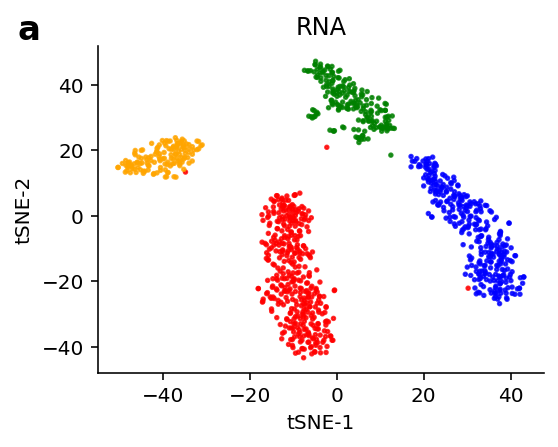

In [14]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b','g', 'orange'])
classes = ['H1', 'BJ', 'K562', 'GM12878']
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
scatter = ax.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = louv_labels, alpha=0.8, cmap=colours)
#ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('RNA')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.text(  # position text relative to Axes
    -0.18, 1.1, 'a', ha='left', va='top', size = 17, weight="bold", transform=ax.transAxes)
plt.savefig('/data/hoan/plots/snare_tsne_RNA.pdf', bbox_inches='tight', pdi=800)
plt.show()

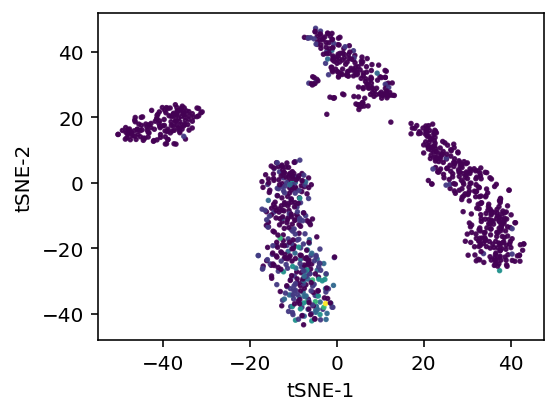

In [15]:
# Annotation of cell types based on known marker genes
plt.figure(figsize=(4,3))
# expr_mat.loc['HLA-DRB1']: 'GM12878', expr_mat.loc['COL1A2']: BJ, expr_mat.loc['EPCAM']: H1
plt.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = expr_mat.loc['EPCAM'], alpha=0.9) 
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()

# ATAC-seq

In [16]:
atacTopic_mat = pd.read_csv('/data/hoan/multiomics/data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_topics.tsv', sep = '\t') 

In [17]:
atac_reduced = PCA(n_components=10).fit_transform(atacTopic_mat.values.T)

In [18]:
atac_reduced.shape

(1047, 10)

In [19]:
tsne_obj = TSNE(init='pca')
tsne = tsne_obj.fit_transform(atac_reduced)

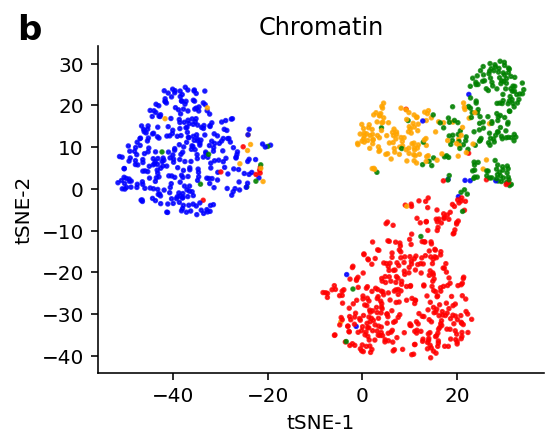

In [20]:
colours = ListedColormap(['r','b','g', 'orange'])
classes = ['H1', 'BJ', 'K562', 'GM12878']

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter = ax.scatter(tsne[:,0], tsne[:,1],s=3 , c = louv_labels, alpha=0.8, cmap=colours)
#ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Chromatin')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.savefig('/data/hoan/plots/snare_tsne_Chromatin.png', bbox_inches='tight')
plt.text(  # position text relative to Axes
    -0.18, 1.1, 'b', ha='left', va='top', size = 17, weight="bold", transform=ax.transAxes)
plt.savefig('/data/hoan/plots/snare_tsne_Chromatin.pdf', bbox_inches='tight', pdi=800)
plt.show()

# Joint visualization

In [21]:
data = {'RNA': expr_reduced, 'Chromatin': atac_reduced}
joint_tsne = JTSNE(init='random').fit_transform(data)

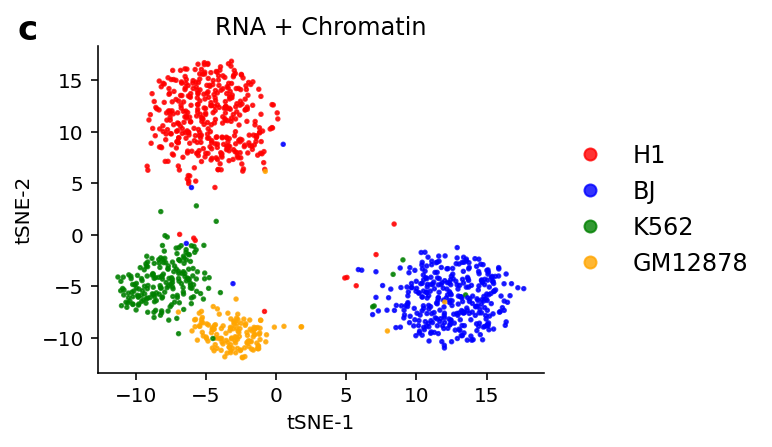

In [29]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter = ax.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = louv_labels, alpha=0.8, cmap=colours)
lgd = ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('RNA + Chromatin')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.savefig('/data/hoan/plots/snare_tsne_RNA_Chromatin.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.text(  # position text relative to Axes
    -0.18, 1.1, 'c', ha='left', va='top', size = 17, weight="bold", transform=ax.transAxes)
plt.savefig('/data/hoan/plots/snare_tsne_RNA_Chromatin.pdf', bbox_inches='tight', pdi=800)
plt.show()